In [89]:
from skimage import io
import itertools
import matplotlib.pyplot as plt
import glob
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


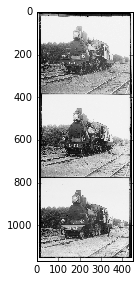

In [79]:
img = io.imread('01-channel-align-pub/small/00458a.png')
io.imshow(img)
io.show()

In [92]:
def align(img, shifts_range=range(-5, 5), metric='mse'):
    
    def cut_frame(img, frame_size_ratio=0.05):

        frame_width = int(img.shape[0] * 0.05)
        frame_height = int(img.shape[1] * 0.05)
        return img[frame_height: -frame_height, frame_width: -frame_width]
    
    def split_into_three_parts(img):
    
        one_third = img.shape[0] // 3 
        return img[:one_third], img[one_third: 2 * one_third], img[2 * one_third:]
    
    def calc_metric(img_part1, img_part2):
        assert img_part1.shape == img_part2.shape
        
        if metric == 'mse':
            total_square_error = ((img_part1 - img_part2) ** 2).sum()
            number_pixels = img_part1.shape[0] * img_part2.shape[1]
            return total_square_error / number_pixels
    
    def find_common_areas(img1, img2, shift_x, shift_y):

        img_part1 = img1[max(0, shift_y): min(img1.shape[0], img2.shape[0],
                                              img1.shape[0] + shift_y, img2.shape[0] + shift_y),
                         max(0, shift_x): min(img1.shape[1], img1.shape[1] + shift_x, img2.shape[1] + shift_x)]
        
        img_part2 = img2[max(0, -shift_y): min(img1.shape[0], img2.shape[0], 
                                               img2.shape[0] - shift_y, img1.shape[0] - shift_y),
                         max(0, -shift_x): min(img2.shape[1], img2.shape[1] - shift_x, img1.shape[1] - shift_x)]

        return img_part1, img_part2
    
    def concatenate_images(shift_x, shift_y):
        img_part1, img_part2 = find_common_areas(images[0], images[1], shift_x, shift_y)
        img_part1, img_part3 = find_common_areas(images[0], images[2], shift_x, shift_y)
        
        return np.array([[[img_part1[i][j], img_part2[i][j], img_part3[i][j]] for j in range(img_part1.shape[1])]\
                        for i in range(img_part1.shape[0])])

    images = split_into_three_parts(img)
    images = map(cut_frame, images)
    
    results = []
    for i, j in [[0, 1], [0, 2], [1, 2]]: 
        score = None
        best_shifts = None
        
        for shift_x, shift_y in itertools.product(shifts_range, shifts_range):
            img_part1, img_part2 = find_common_areas(images[i], images[j], shift_x, shift_y)
            current_score = calc_metric(img_part1, img_part2)
            
            if score is None or current_score < score:
                score = current_score
                best_shifts = [shift_x, shift_y]
                
        results.append([score, best_shifts])
    
    results.sort(key=lambda x: np.fabs(x[1][0]))
    best_shift_y = max([res[1][0] for res in results])
    best_shift_x = max([res[1][1] for res in results])
    
    #print best_shift_x, best_shift_y
    return concatenate_images(best_shift_y, best_shift_x)

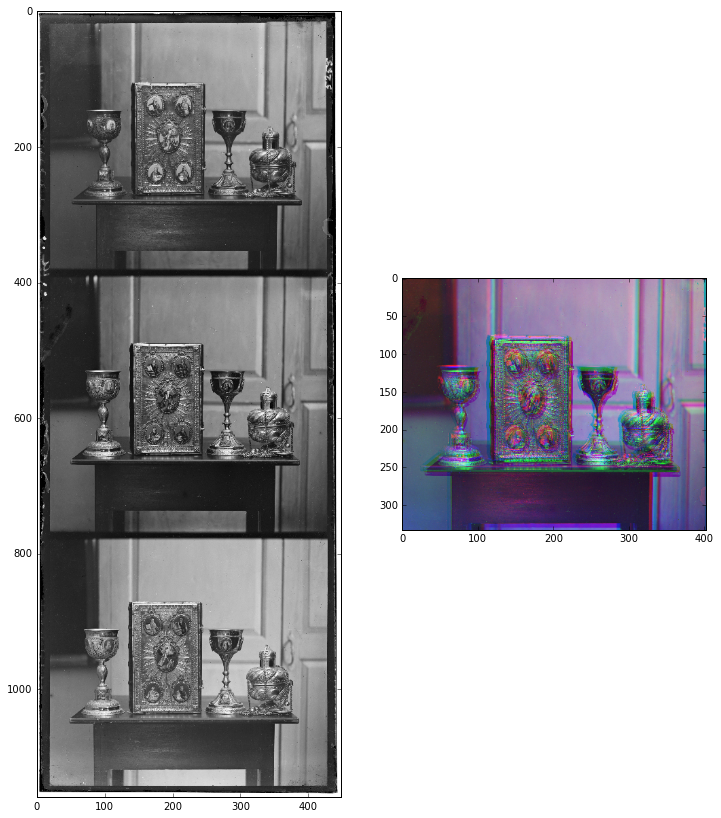

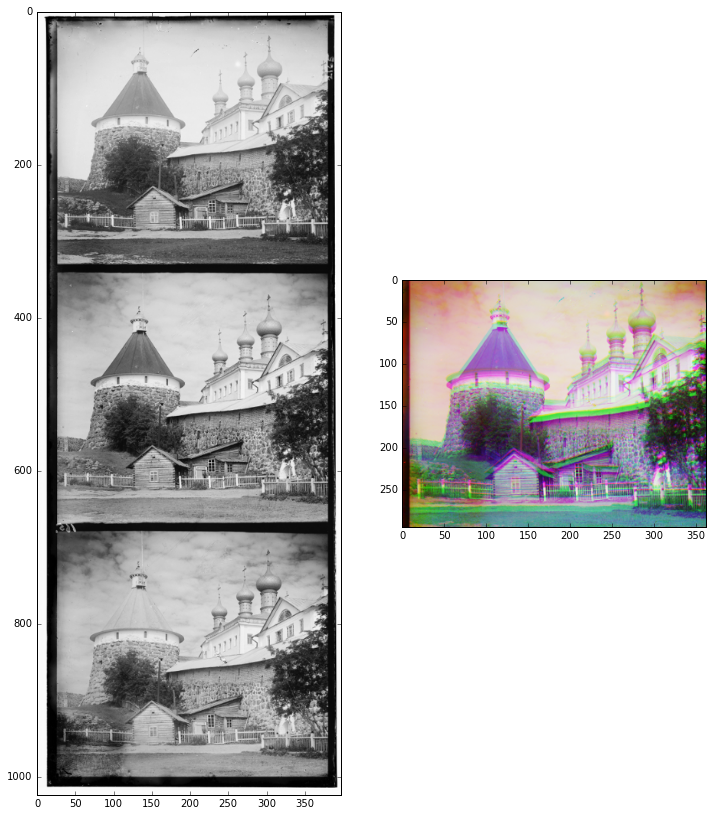

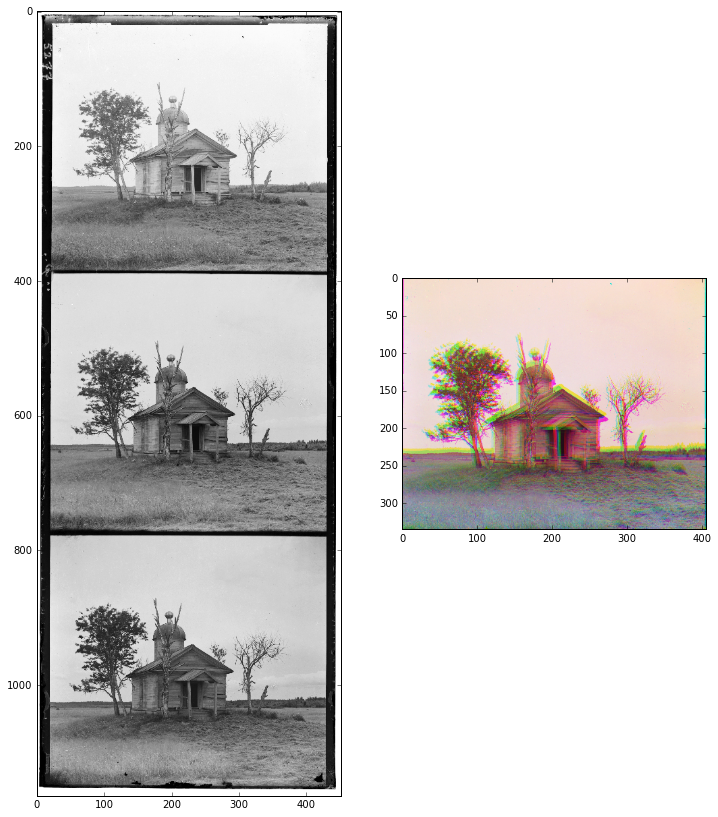

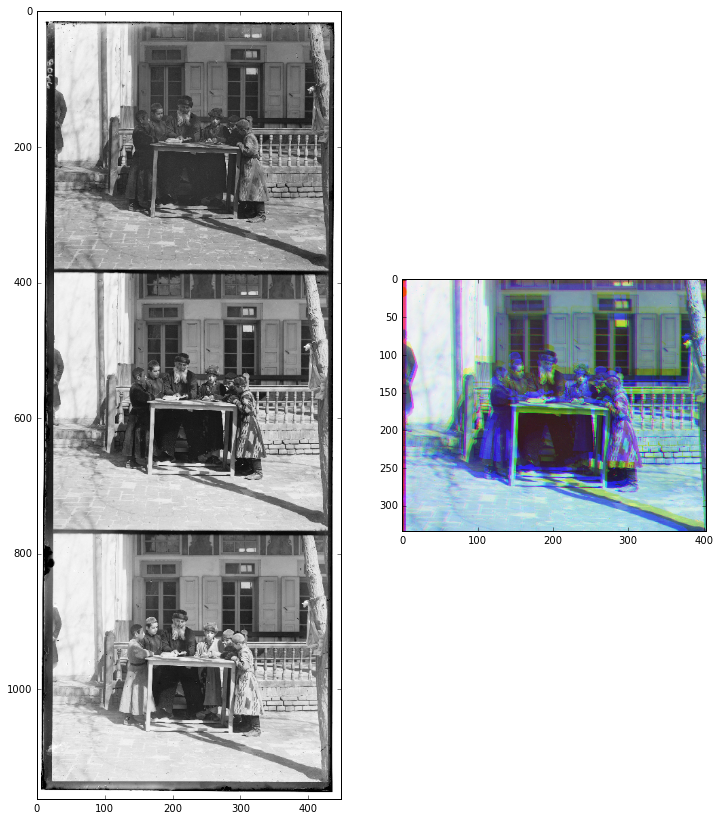

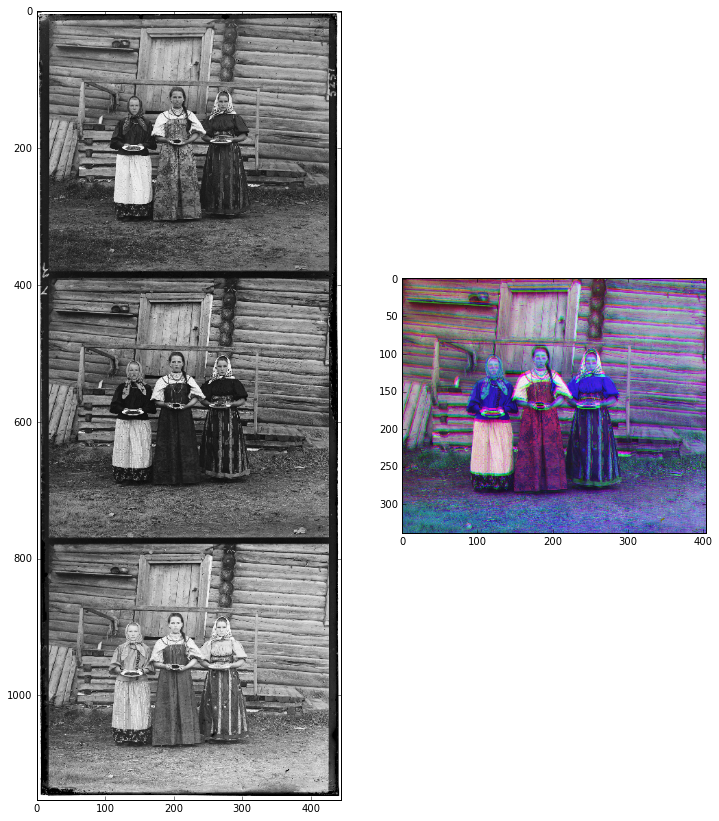

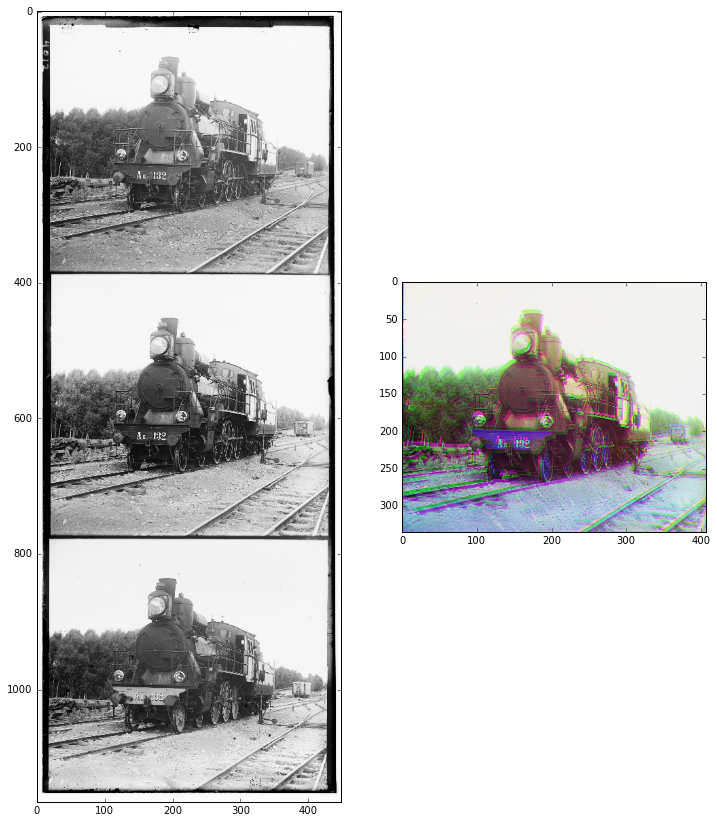

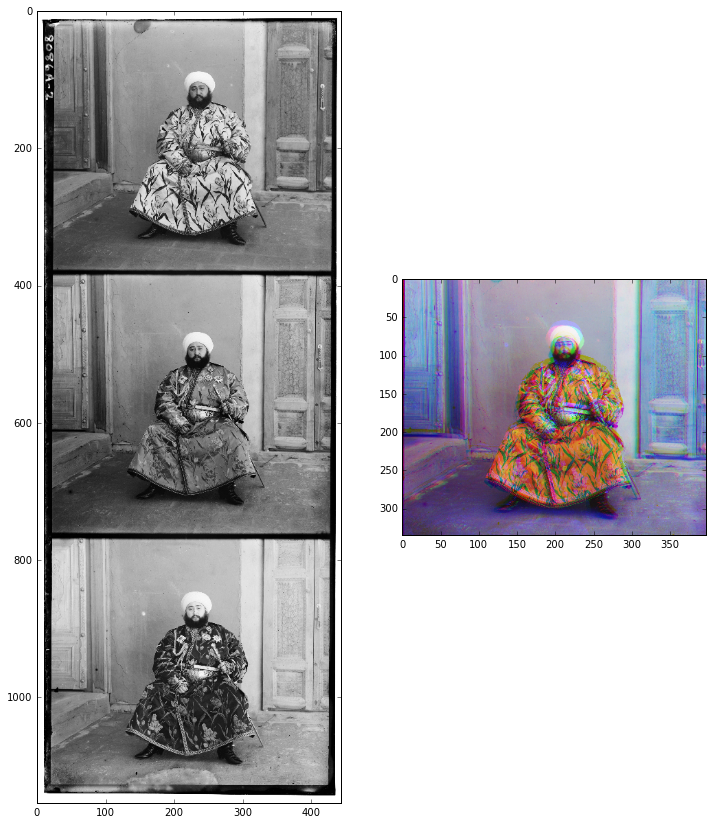

In [104]:
all_input_files = glob.glob(os.path.join('01-channel-align-pub/small/', '*'))

for file_path in all_input_files:
    img = io.imread(file_path)
    plt.figure(figsize=(12,16))
    ax1 = plt.subplot(121)
    ax1.imshow(img, cmap='gray')
    ax2 = plt.subplot(122)
    result = align(img, shifts_range=range(-10,10))
    ax2.imshow(result)
    plt.show()